# Variable Depth UNet++ Implementation

Authors:

- Feilong Meng, feilongm@umich.edu
- Peijing Li, peijli@umich.edu
- Yongxiang Zhao, zyxleo@umich.edu

All code cells, unless explicitly noted, are asserted to be 100% original.
All libraries used and external source code referenced will be credited in the bibliography of the project report.

## Imports and Global Variables

In [ ]:
# Pytorch imports
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
# Data science related imports
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.colorbar import constrained_layout
# System imports
from pathlib import Path
import glob, os, math, time, itertools
import warnings
warnings.filterwarnings("ignore")

### Hyperparameters

The following hyperparameters are adopted from
https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b
- `HIDDEN_CH`
- `LEARNING_RATE`
- `STEP_SIZE`
- `GAMMA`

In [ ]:
IN_SIZE = 224 # desired height/width of inputs to model
IN_SHAPE = [IN_SIZE, IN_SIZE] # height*width of input images to the model
RAW_SHAPE = [1752, 2045] # shape of images in dataset
TRAIN_BATCH = 4 # size of training batch
TEST_BATCH = 2 # size of testing batch
HIDDEN_CH = 64 # base value of hidden channels at first convolution layer
SMOOTHING = 1 # smoothing value applied to dice loss to prevent zero division
EPOCHS = 40 # default number of epochs
LEARNING_RATE = 1e-4 # default learning rate of optimizer
STEP_SIZE = 10  # step size of scheduler
GAMMA = 0.1 # gamma of scheduler
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


## Dataset

Original dataset contains 50 training and 51 validation samples. Manually modified to include 81 training and 20 validation samples. You can access our dataset at https://www.dropbox.com/s/d0hhrsraycouk9p/Drishti-GS1-EECS442-FA22.zip?dl=0

The original, unmodified dataset is available at http://cvit.iiit.ac.in/projects/mip/drishti-gs/mip-dataset2/Home.php.
The paper describing the original dataset is available at https://ieeexplore.ieee.org/document/6867807

### Download data

In [ ]:
# !wget https://www.dropbox.com/s/d0hhrsraycouk9p/Drishti-GS1-EECS442-FA22.zip
!wget https://github.com/peijli/peijli.github.io/releases/download/Lfs/Drishti-GS1-EECS442-FA22.zip
!unzip Drishti-GS1-EECS442-FA22.zip
IMG_ROOT = os.path.join(os.getcwd(), "Drishti-GS1")

--2022-12-16 18:58:28--  https://www.dropbox.com/s/d0hhrsraycouk9p/Drishti-GS1-EECS442-FA22.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/d0hhrsraycouk9p/Drishti-GS1-EECS442-FA22.zip [following]
--2022-12-16 18:58:28--  https://www.dropbox.com/s/raw/d0hhrsraycouk9p/Drishti-GS1-EECS442-FA22.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc13909df6626e757cd3bec92797.dl.dropboxusercontent.com/cd/0/inline/Byy5TDahj0ItZcyzSgSZP2UVAjESOAch-VWg9eH7m4AKT4bl8pKDa-SDtsS9OSIF9xq7jkW8IXRvlbjewXI1K2dUC8M3dJhfq3Xv3FCScG5ABD785FwUrJeiwKVlWHjwdsHNM8bbABJeiy3oBBE14m-m_FM0-0YSdPstW9AXbarTww/file# [following]
--2022-12-16 18:58:28--  https://uc13909df6626e757cd3bec92797.dl.dropboxusercontent.com/cd/0/inline/Byy5TDahj0ItZcyzSgSZP2UVAjESOAch

### Dataloader Implementation

The general structure of this dataloader is inspired from the [Problem Set 6 notebook](https://drive.google.com/file/d/12pxuMjssm8GYzvUG1hWBegLuDcs1ZG77/view?usp=sharing)

In [ ]:
class DrishtiDataset(Dataset):
    def __init__(self, train:bool):
        super(DrishtiDataset, self).__init__()
        # directory names for training and testing files are different
        mode = "Training" if train else "Test"
        gt_dir = "GT" if train else "Test_GT"

        # get image paths
        self.img_paths = glob.glob(
            os.path.join(IMG_ROOT, mode, "Images", "*.png"))

        # get paths for ground truths
        self.od_paths, self.cup_paths, self.center_paths = [], [], []
        for path in self.img_paths:
            # filename stem containing index of sample
            stem = Path(path).stem
            # ground truths for optic disk masks
            self.od_paths.append(os.path.join(
                IMG_ROOT, mode, gt_dir, stem, "SoftMap", f"{stem}_ODsegSoftmap.png"))
            # ground truths for cup masks
            self.cup_paths.append(os.path.join(
                IMG_ROOT, mode, gt_dir, stem, "SoftMap", f"{stem}_cupsegSoftmap.png"))
            # grab references for center points of OD and cup labels
            # for use in cropping images
            self.center_paths.append(os.path.join(
                IMG_ROOT, mode, gt_dir, stem, "AvgBoundary", f"{stem}_diskCenter.txt"))

        # resize image to [224, 224] from higher resolution
        self.transform = transforms.Compose([
            transforms.Resize(IN_SHAPE),
            transforms.ToTensor(),
        ])

    def crop(self, img, od, cup, center_pt):
        '''
        Crop a set of input images and labels to squares according to the
        centerpoint of optic nerve head region
        '''
        left_offset = center_pt[1] - RAW_SHAPE[0] / 2
        left_offset = left_offset if left_offset > 0 else 0
        img = TF.crop(img, top=0, left=left_offset,
                        height=RAW_SHAPE[0], width=RAW_SHAPE[0])
        od = TF.crop(od, top=0, left=left_offset,
                        height=RAW_SHAPE[0], width=RAW_SHAPE[0])
        cup = TF.crop(cup, top=0, left=left_offset,
                        height=RAW_SHAPE[0], width=RAW_SHAPE[0])
        return img, od, cup

    def __getitem__(self, index):
        # read center point label of mask
        center_pt = []
        with open(self.center_paths[index]) as fh:
            center_pt = [int(n) for n in fh.read().split()]
        # open images
        img = Image.open(self.img_paths[index])
        od = Image.open(self.od_paths[index])
        cup = Image.open(self.cup_paths[index])
        # transform images
        img, od, cup = self.crop(img, od, cup, center_pt)
        img = self.transform(img)
        od = self.transform(od)
        cup = self.transform(cup)
        return img.to(DEVICE), torch.cat((od, cup)).to(DEVICE)

    def __len__(self):
        return len(self.img_paths)

In [ ]:
# define dataloaders
train_data = DrishtiDataset(train=True)
test_data = DrishtiDataset(train=False)
train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH, shuffle=True)
test_loader = DataLoader(test_data, batch_size=TEST_BATCH, shuffle=False)
print(f"Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

Training samples: 81, Testing samples: 20


### Image visualization

Note that we are given image of a retina and are trying to predict a monochrome mask for the optic disk (the orange circle in the middle) and the cup (the bright yellow part of the orange circle).

We concatenate the OD and cup values into a two-channel label that the model would output.

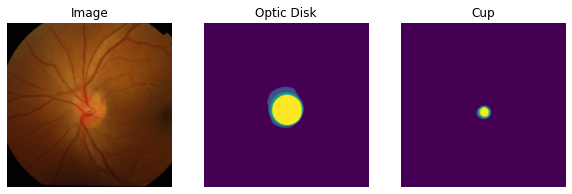

In [ ]:
# grab a sample from the testing dataset
test = test_loader.__iter__().__next__()
# input image from the sample
img = np.asarray(test[0][0].cpu()).transpose(1, 2, 0)
# optic disc and cup masks from the sample
od, cup = np.asarray(test[1][0][0].cpu()), np.asarray(test[1][0][1].cpu())

# three subplots for the three images
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(10)
ax[0].imshow(img)
ax[1].imshow(od)
ax[2].imshow(cup)
ax[0].title.set_text("Image")
ax[1].title.set_text("Optic Disk")
ax[2].title.set_text("Cup")
for a in ax: a.axis("off")

## Model implementation

The baseline model is adopted from https://towardsdatascience.com/biomedical-image-segmentation-unet-991d075a3a4b.
The varied-depth implementation is original and will be the main focal point of further evaluations and assessment.


### Vanilla UNet

In [ ]:
class UNet(nn.Module):
    def conv_block(self, in_ch, out_ch) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def __init__(self, in_ch=3, out_ch=2):
        super(UNet, self).__init__()
        filters = [64, 128, 256, 512, 1024]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = self.conv_block(in_ch, 64)
        self.conv2 = self.conv_block(64, 128)
        self.conv3 = self.conv_block(128, 256)
        self.conv4 = self.conv_block(256, 512)
        self.conv5 = self.conv_block(512, 1024)
        self.deconv1 = self.conv_block(1536, 512)
        self.deconv2 = self.conv_block(768, 256)
        self.deconv3 = self.conv_block(384, 128)
        self.deconv4 = self.conv_block(192, 64)
        self.deconv5 = self.conv_block(64, out_ch)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        x6 = self.deconv1(torch.cat([x4, self.Up(x5)], 1))
        x7 = self.deconv2(torch.cat([x3, self.Up(x6)], 1))
        x8 = self.deconv3(torch.cat([x2, self.Up(x7)], 1))
        x9 = self.deconv4(torch.cat([x1, self.Up(x8)], 1))
        x10 = self.deconv5(x9)
        return x10


### Baseline/reference model

The following cell is mostly adopted from https://gist.github.com/jinglescode/9d9ed6027e62e389e3165b59209e838e.
We will compare this fixed-depth implementation with our varied-length implementation below.

In [ ]:
class Nested_UNet(nn.Module):

    def conv_block(self, in_ch, mid_ch, out_ch) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_ch, mid_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(mid_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def __init__(self, in_ch=3, out_ch=1):
        super(Nested_UNet, self).__init__()
        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv0_0 = self.conv_block(in_ch, filters[0], filters[0])
        self.conv1_0 = self.conv_block(filters[0], filters[1], filters[1])
        self.conv2_0 = self.conv_block(filters[1], filters[2], filters[2])
        self.conv3_0 = self.conv_block(filters[2], filters[3], filters[3])
        self.conv4_0 = self.conv_block(filters[3], filters[4], filters[4])
        self.conv0_1 = self.conv_block(filters[0] + filters[1], filters[0], filters[0])
        self.conv1_1 = self.conv_block(filters[1] + filters[2], filters[1], filters[1])
        self.conv2_1 = self.conv_block(filters[2] + filters[3], filters[2], filters[2])
        self.conv3_1 = self.conv_block(filters[3] + filters[4], filters[3], filters[3])
        self.conv0_2 = self.conv_block(filters[0]*2 + filters[1], filters[0], filters[0])
        self.conv1_2 = self.conv_block(filters[1]*2 + filters[2], filters[1], filters[1])
        self.conv2_2 = self.conv_block(filters[2]*2 + filters[3], filters[2], filters[2])
        self.conv0_3 = self.conv_block(filters[0]*3 + filters[1], filters[0], filters[0])
        self.conv1_3 = self.conv_block(filters[1]*3 + filters[2], filters[1], filters[1])
        self.conv0_4 = self.conv_block(filters[0]*4 + filters[1], filters[0], filters[0])
        self.final = nn.Conv2d(filters[0], out_ch, kernel_size=1)

    def forward(self, x):

        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.Up(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.Up(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.Up(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.Up(x4_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.Up(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.Up(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.Up(x3_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.Up(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.Up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.Up(x1_3)], 1))
        output = self.final(x0_4)
        return output

### Variable-depth Implementation

This original variable-depth implementation takes in parameter `depth` to generate a densely connected UNet++ model.
It is expected that the generated model to be analogous to the above baseline model when `depth=5`.

In [ ]:
class UNetPlusPlus(nn.Module):

    def nested_convolution_block(self, in_ch, out_ch):
        '''
        The nested convolution block is adopted from the reference model above
        '''
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def __init__(self, in_ch=3, out_ch=1, hidden_ch=HIDDEN_CH, depth=5, shape=IN_SHAPE):

        super(UNetPlusPlus, self).__init__()
        # pooling function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # upsampling function
        self.Up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # final parallel convolution layer
        self.final = nn.Conv2d(hidden_ch, out_ch, kernel_size=1)
        self.shape = shape # image shape
        self.depth = depth # network depth

        # define list of channel sizes
        # example: [3, 64, 128, 256, 512, 1024]
        # for in_ch=3 and hidden_ch=64
        ch_sizes = [in_ch]
        for i in range(self.depth):
            ch_sizes.append(hidden_ch * (2 ** i))

        # construct convolution backbone
        self.convs = nn.ModuleList([nn.ModuleList([
                self.nested_convolution_block(
                    ch_sizes[j], ch_sizes[j + 1]) for j in range(self.depth)
            ])])

        # construct additional convolution modules for dense connections
        for i in range(1, self.depth):
            self.convs.append(nn.ModuleList([
                self.nested_convolution_block(
                    ch_sizes[j + 1] * i + ch_sizes[j + 2],
                    ch_sizes[j + 1]) for j in range(self.depth - i
            )]))

    def forward(self, x):

        xc = [[None] * self.depth] * self.depth

        # backbone
        xc[0][0] = self.convs[0][0](x) # 3 -> 64
        for j in range(1, self.depth):
            xc[0][j] = self.convs[0][j](self.pool(xc[0][j - 1]))

        # dense connections
        for i in range(1, self.depth):
            for j in range(0, self.depth - i):
                concat = [xc[k][j] for k in range(i)]
                concat.append(self.Up(xc[i - 1][j + 1]))
                xc[i][j] = self.convs[i][j](torch.cat(concat, 1))

        # linear output convolution
        output = self.final(xc[self.depth - 1][0])

        return output

## Training the Model

### Loss function: dice-bce loss

Compute dice and binary-cross-entropy loss values for each channel of the output then outputting an average loss across all channels.
Note that we first apply a sigmoid activation function to the inputs to `CustomDiceLoss` to keep them within the range of [0,1], otherwise we get some wacky negative losses.

The `CustomDiceLoss` is implemented in a similar fashion to https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook, with referenced code in the computation of `intersection` and `dice`,  the signmoid activation, and the smoothing operations.  

In [ ]:
class CustomDiceLoss(nn.Module):
    def __init__(self, activation=True, smooth=SMOOTHING):
        super(CustomDiceLoss, self).__init__()
        self.activation = activation
        self.smooth = smooth

    def forward(self, inputs, targets):

        # smooth input and fit it to range [0,1]
        if self.activation:
            inputs = F.sigmoid(inputs).exp()

        # place channel at first dimension
        inputs = inputs.transpose(1,0)
        targets = targets.transpose(1,0)
        loss = None

        # there should be two channels for od and cup
        for i in range(inputs.shape[0]):
            # compute dice loss for each channel
            input = inputs[i].flatten()
            target = targets[i].flatten()
            intersection = (input * target).sum()
            dice = 1 - (2. * intersection + self.smooth) /\
                (input.sum() + target.sum() + self.smooth)
            if loss is None: loss = dice
            else: loss += dice

        # average loss over channels
        return loss / inputs.shape[0]

In [ ]:
class CustomBCELoss(nn.Module):
    def __init__(self):
        super(CustomBCELoss, self).__init__()
    def forward(self, inputs, targets):
        # place channel at first dimension
        inputs = inputs.transpose(1,0)
        targets = targets.transpose(1,0)
        loss = None
        # there should be two channels for od and cup
        for i in range(inputs.shape[0]):
            # compute bce loss for each channel
            input = inputs[i]
            target = targets[i]
            bce = F.binary_cross_entropy_with_logits(input, target)
            if loss is None: loss = bce
            else: loss += bce
        # average loss over channels
        return loss / inputs.shape[0]

### Method for training model

The `train` method does the following:
- Train model with the joint-Dice-BCE loss, Adam optimizer and the StepLR scheduler.
- Report training times, training loss, and validation loss after each epoch.
- Save model state dict for the epoch with the best validation losss
- Return histories of training and validation losses for visualization

The `print` statements used to monitor training progress and time is adopted from the [Problem Set 6 notebook](https://drive.google.com/file/d/12pxuMjssm8GYzvUG1hWBegLuDcs1ZG77/view?usp=sharing).

In [ ]:
def train(model, train_loader, test_loader, num_epochs=EPOCHS, filename="best-model.pt"):

    # loss functions
    dice_loss = CustomDiceLoss(activation=True)
    bce_loss = CustomBCELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    train_bce_hist, train_dice_hist = [], []
    test_bce_hist, test_dice_hist = [], []
    min_epoch, min_loss = 0, math.inf

    for epoch in range(num_epochs):

        epoch_start = time.time()

        # training loop
        model.train()
        train_losses = []
        for input, target in train_loader:
            optimizer.zero_grad()
            output = model(input)

            # loss functions
            dice = dice_loss(output, target)
            bce = bce_loss(output, target)
            loss = dice + bce

            # monitor loss values
            dice_val = dice.detach().item()
            bce_val = bce.detach().item()
            loss_val = dice_val + bce_val
            train_losses.append(loss_val)
            train_bce_hist.append(bce_val)
            train_dice_hist.append(dice_val)

            # backpropagation
            loss.backward()
            optimizer.step()
        scheduler.step()

        # validation loop
        model.eval()
        test_losses = []
        for input, target in test_loader:
            # compute model output
            output = model(input)
            # compute loss values
            dice_val = dice_loss(output, target).detach().item()
            bce_val = bce_loss(output, target).detach().item()
            loss_val = dice_val + bce_val
            # record loss values
            test_losses.append(loss_val)
            test_bce_hist.append(bce_val)
            test_dice_hist.append(dice_val)

        # conclude epoch and report losses
        epoch_end = time.time()
        per_epoch = epoch_end - epoch_start
        print('[%d/%d] - using time: %.2f seconds' %\
              ((epoch + 1), num_epochs, per_epoch))
        print('Training loss: %.3f' %\
              (torch.mean(torch.FloatTensor(train_losses))))
        loss_val = torch.mean(torch.FloatTensor(test_losses))
        print('Validation loss: %.3f' % loss_val)
        # evaluate validation loss
        if loss_val < min_loss:
            min_epoch, min_loss = epoch, loss_val
            # save best model
            torch.save(model.state_dict(), filename)

    # conclude training
    print(f'Minimum validation loss of {min_loss} achieved at epoch {min_epoch+1}')
    return train_bce_hist, train_dice_hist, test_bce_hist, test_dice_hist

### Visualizing Output

In [ ]:
def avg_by_epoch(loss_hist, epochs=EPOCHS):
    '''Compute averages of loss values over each epoch from history list'''
    iter_per_epoch = int(len(loss_hist) / epochs)
    loss_hist = np.asarray(loss_hist).reshape(-1, iter_per_epoch)
    return np.average(loss_hist, axis=1)

In [ ]:
def graph_losses(train_bce, train_dice, test_bce, test_dice, epochs=EPOCHS):
    '''Plot the change in the dice, BCE, and total loss values over each epoch'''

    x_val = np.arange(epochs)
    train_bce = avg_by_epoch(train_bce, epochs)
    train_dice = avg_by_epoch(train_dice, epochs)
    test_bce = avg_by_epoch(test_bce, epochs)
    test_dice = avg_by_epoch(test_dice, epochs)

    fig, ax = plt.subplots(3, 1, constrained_layout=True)
    ax = ax.flatten()
    # train_x = np.arange(len(train_bce))
    # test_x = np.linspace(0, len(train_bce)-1, len(test_bce))
    fig.set_figwidth(6)
    fig.set_figheight(9)
    ax[0].plot(x_val, train_bce)
    ax[0].plot(x_val, test_bce)
    ax[0].title.set_text("BCE losses")
    ax[1].plot(x_val, train_dice)
    ax[1].plot(x_val, test_dice)
    ax[1].title.set_text("Dice losses")
    ax[2].plot(x_val, train_bce + train_dice)
    ax[2].plot(x_val, test_bce + test_dice)
    ax[2].title.set_text("Total losses")
    for a in ax:
        a.legend(["Train", "Test"])
        a.set_xlabel("Epochs")

In [ ]:
def graph_preds(model, test_loader):
    '''
    Run trained model on a test sample
    and visualize both the predicted and ground-truth masks
    '''

    test = test_loader.__iter__().__next__()
    od_pred, cup_pred = model(test[0])[0].cpu().detach().numpy()
    img = np.asarray(test[0][0].cpu()).transpose(1, 2, 0)
    od, cup = np.asarray(test[1][0][0].cpu()), np.asarray(test[1][0][1].cpu())
    fig, ax = plt.subplots(2, 3)
    fig.set_figwidth(10)

    ax = ax.flatten()
    ax[0].imshow(img)
    ax[1].imshow(od)
    ax[2].imshow(cup)
    ax[3].imshow(od_pred)
    ax[4].imshow(cup_pred)
    ax[0].title.set_text("Image")
    ax[1].title.set_text("GT Optic Disk")
    ax[2].title.set_text("GT Cup")
    ax[3].title.set_text("Predicted OD")
    ax[4].title.set_text("Predicted Cup")
    for a in ax:
        a.axis("off")

### Runner function

Note that we load the saved model parameters for final visualization of model prediction.

In [ ]:
def train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        baseline=False, plusplus=True, depth=5
    ):
    '''Runner function of training and evaluation of model of given depth'''
    model = None
    fn = ""
    # define models
    if baseline:
        model = Nested_UNet(out_ch=2).to(DEVICE)
        fn = "best-model-baseline.pt"
    elif plusplus:
        model = UNetPlusPlus(out_ch=2, depth=depth).to(DEVICE)
        fn = f"best-model-{depth}-deep.pt"
    else:
        model = UNet(in_ch=3, out_ch=2).to(DEVICE)
        fn = "best-model-unet.pt"
    # train model
    train_bce, train_dice, test_bce, test_dice = \
        train(model, train_loader, test_loader, EPOCHS, fn)
    # load best model
    model.load_state_dict(torch.load(fn))
    model.to(DEVICE)
    # visualize results
    graph_losses(train_bce, train_dice, test_bce, test_dice, EPOCHS)
    graph_preds(model, test_loader)
    # delete model to save graphic memory
    del model

In [ ]:
def view_model(baseline=False, plusplus=True, depth=5):
    '''Print summary of model for given depth'''
    model = None
    # define models
    if baseline:
        model = Nested_UNet(out_ch=2).to(DEVICE)
    elif plusplus:
        model = UNetPlusPlus(out_ch=2, depth=depth).to(DEVICE)
    else:
        model = UNet(in_ch=3, out_ch=2).to(DEVICE)
    print(summary(model, (3, 224, 224)))
    # delete model to save graphic memory
    del model

## Execution Results

We first print a summary of the model layers, parameters, and storage space.
Then we train each model for 40 epochs and report graphs of loss values and final prediction results.

In [ ]:
view_model(plusplus=False)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 17.27 seconds
Training loss: 1.673
Validation loss: 1.653
[2/40] - using time: 16.44 seconds
Training loss: 1.636
Validation loss: 1.644
[3/40] - using time: 16.28 seconds
Training loss: 1.625
Validation loss: 1.635
[4/40] - using time: 16.58 seconds
Training loss: 1.610
Validation loss: 1.619
[5/40] - using time: 16.24 seconds
Training loss: 1.602
Validation loss: 1.616
[6/40] - using time: 16.34 seconds
Training loss: 1.601
Validation loss: 1.611
[7/40] - using time: 16.20 seconds
Training loss: 1.600
Validation loss: 1.611
[8/40] - using time: 16.24 seconds
Training loss: 1.598
Validation loss: 1.609
[9/40] - using time: 16.16 seconds
Training loss: 1.599
Validation loss: 1.669
[10/40] - using time: 16.12 seconds
Training loss: 1.602
Validation loss: 1.620
[11/40] - using time: 16.17 seconds
Training loss: 1.600
Validation loss: 1.608
[12/40] - using time: 16.80 seconds
Training loss: 1.599
Validation loss: 1.608
[13/40] - using time: 16.08 seconds
Training loss

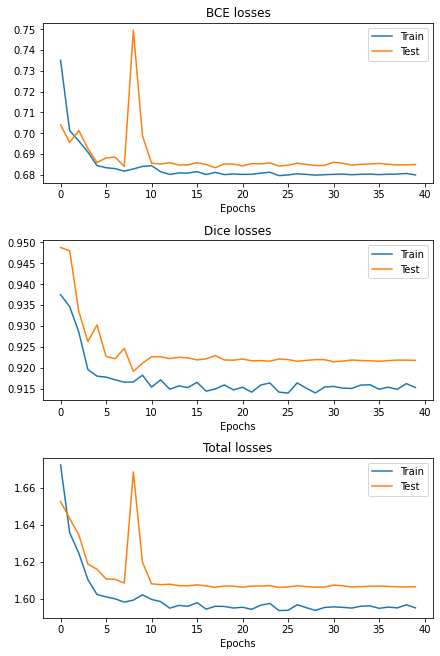

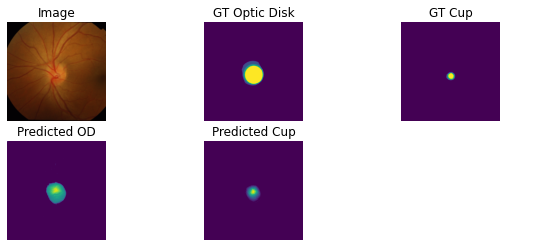

In [ ]:
train_and_evaluate(plusplus=False)

### Baseline

In [ ]:
view_model(baseline=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 25.55 seconds
Training loss: 1.582
Validation loss: 1.592
[2/40] - using time: 25.60 seconds
Training loss: 1.450
Validation loss: 1.488
[3/40] - using time: 25.26 seconds
Training loss: 1.418
Validation loss: 1.423
[4/40] - using time: 25.28 seconds
Training loss: 1.395
Validation loss: 1.400
[5/40] - using time: 25.32 seconds
Training loss: 1.372
Validation loss: 1.373
[6/40] - using time: 25.41 seconds
Training loss: 1.351
Validation loss: 1.358
[7/40] - using time: 25.30 seconds
Training loss: 1.334
Validation loss: 1.359
[8/40] - using time: 25.34 seconds
Training loss: 1.330
Validation loss: 1.347
[9/40] - using time: 25.21 seconds
Training loss: 1.315
Validation loss: 1.332
[10/40] - using time: 25.22 seconds
Training loss: 1.300
Validation loss: 1.304
[11/40] - using time: 25.46 seconds
Training loss: 1.289
Validation loss: 1.301
[12/40] - using time: 25.72 seconds
Training loss: 1.288
Validation loss: 1.297
[13/40] - using time: 25.25 seconds
Training loss

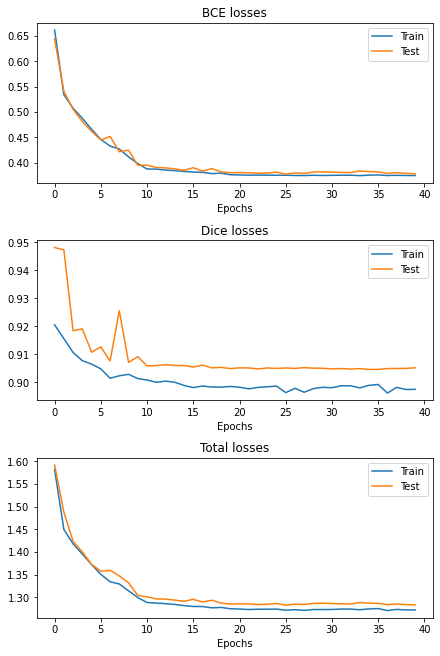

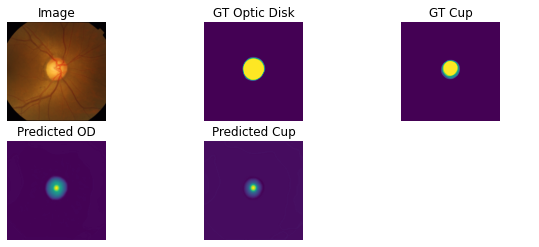

In [ ]:
train_and_evaluate(baseline=True)

### Depth = 2

In [ ]:
view_model(depth=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
         Upsample-14        [-1, 128, 2

[1/40] - using time: 15.17 seconds
Training loss: 1.448
Validation loss: 1.473
[2/40] - using time: 16.57 seconds
Training loss: 1.357
Validation loss: 1.353
[3/40] - using time: 15.23 seconds
Training loss: 1.322
Validation loss: 1.311
[4/40] - using time: 15.33 seconds
Training loss: 1.299
Validation loss: 1.292
[5/40] - using time: 15.25 seconds
Training loss: 1.282
Validation loss: 1.271
[6/40] - using time: 15.18 seconds
Training loss: 1.256
Validation loss: 1.253
[7/40] - using time: 15.12 seconds
Training loss: 1.240
Validation loss: 1.235
[8/40] - using time: 15.12 seconds
Training loss: 1.225
Validation loss: 1.224
[9/40] - using time: 14.97 seconds
Training loss: 1.211
Validation loss: 1.211
[10/40] - using time: 15.20 seconds
Training loss: 1.196
Validation loss: 1.190
[11/40] - using time: 15.13 seconds
Training loss: 1.182
Validation loss: 1.187
[12/40] - using time: 15.20 seconds
Training loss: 1.182
Validation loss: 1.187
[13/40] - using time: 15.52 seconds
Training loss

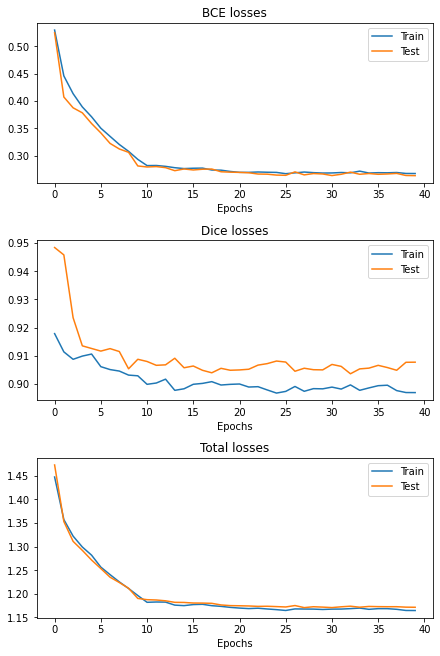

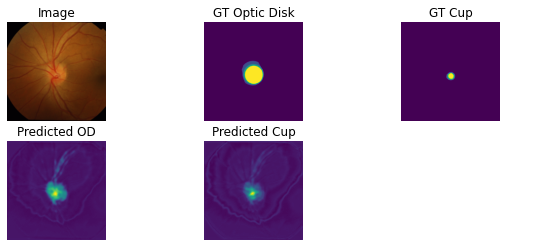

In [ ]:
train_and_evaluate(depth=2)

### Depth = 3

In [ ]:
view_model(depth=3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 15.97 seconds
Training loss: 1.474
Validation loss: 1.497
[2/40] - using time: 15.85 seconds
Training loss: 1.355
Validation loss: 1.386
[3/40] - using time: 15.81 seconds
Training loss: 1.320
Validation loss: 1.313
[4/40] - using time: 15.76 seconds
Training loss: 1.289
Validation loss: 1.284
[5/40] - using time: 15.84 seconds
Training loss: 1.267
Validation loss: 1.275
[6/40] - using time: 15.96 seconds
Training loss: 1.249
Validation loss: 1.270
[7/40] - using time: 15.82 seconds
Training loss: 1.235
Validation loss: 1.242
[8/40] - using time: 15.95 seconds
Training loss: 1.217
Validation loss: 1.228
[9/40] - using time: 15.79 seconds
Training loss: 1.206
Validation loss: 1.214
[10/40] - using time: 15.74 seconds
Training loss: 1.194
Validation loss: 1.203
[11/40] - using time: 15.97 seconds
Training loss: 1.185
Validation loss: 1.195
[12/40] - using time: 15.81 seconds
Training loss: 1.181
Validation loss: 1.188
[13/40] - using time: 15.87 seconds
Training loss

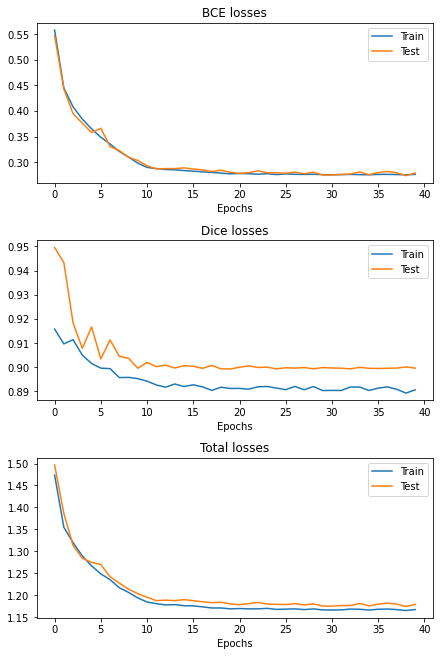

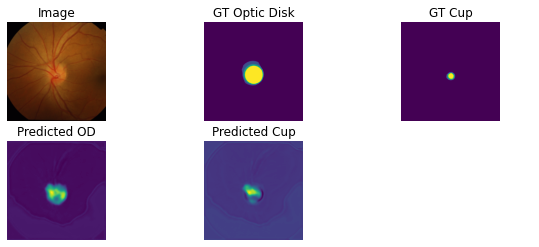

In [ ]:
train_and_evaluate(depth=3)

### Depth = 4

In [ ]:
view_model(depth=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 18.38 seconds
Training loss: 1.464
Validation loss: 1.522
[2/40] - using time: 18.43 seconds
Training loss: 1.337
Validation loss: 1.368
[3/40] - using time: 18.33 seconds
Training loss: 1.316
Validation loss: 1.314
[4/40] - using time: 18.32 seconds
Training loss: 1.287
Validation loss: 1.289
[5/40] - using time: 18.29 seconds
Training loss: 1.268
Validation loss: 1.265
[6/40] - using time: 18.23 seconds
Training loss: 1.249
Validation loss: 1.274
[7/40] - using time: 18.09 seconds
Training loss: 1.236
Validation loss: 1.253
[8/40] - using time: 18.25 seconds
Training loss: 1.221
Validation loss: 1.244
[9/40] - using time: 18.35 seconds
Training loss: 1.213
Validation loss: 1.228
[10/40] - using time: 18.19 seconds
Training loss: 1.196
Validation loss: 1.199
[11/40] - using time: 18.06 seconds
Training loss: 1.190
Validation loss: 1.200
[12/40] - using time: 19.35 seconds
Training loss: 1.188
Validation loss: 1.199
[13/40] - using time: 18.28 seconds
Training loss

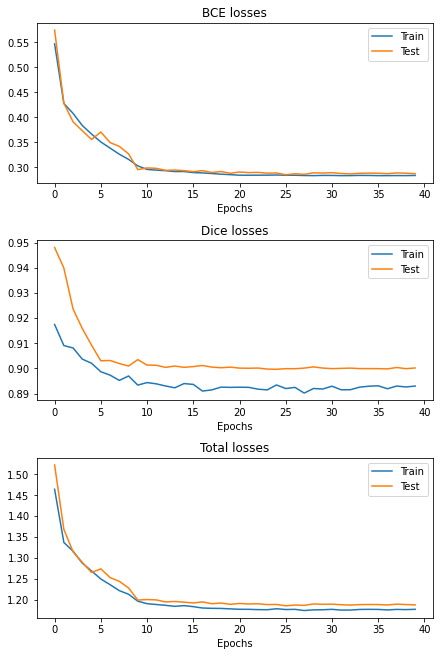

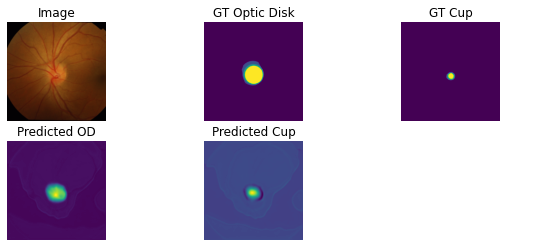

In [ ]:
train_and_evaluate(depth=4)

### Depth = 5

In [ ]:
view_model(depth=5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 24.85 seconds
Training loss: 1.460
Validation loss: 1.461
[2/40] - using time: 25.00 seconds
Training loss: 1.347
Validation loss: 1.347
[3/40] - using time: 25.01 seconds
Training loss: 1.315
Validation loss: 1.320
[4/40] - using time: 24.95 seconds
Training loss: 1.294
Validation loss: 1.346
[5/40] - using time: 24.97 seconds
Training loss: 1.280
Validation loss: 1.293
[6/40] - using time: 25.05 seconds
Training loss: 1.268
Validation loss: 1.282
[7/40] - using time: 25.02 seconds
Training loss: 1.260
Validation loss: 1.267
[8/40] - using time: 24.94 seconds
Training loss: 1.244
Validation loss: 1.260
[9/40] - using time: 24.94 seconds
Training loss: 1.231
Validation loss: 1.239
[10/40] - using time: 25.19 seconds
Training loss: 1.220
Validation loss: 1.226
[11/40] - using time: 25.96 seconds
Training loss: 1.209
Validation loss: 1.222
[12/40] - using time: 24.99 seconds
Training loss: 1.210
Validation loss: 1.222
[13/40] - using time: 25.03 seconds
Training loss

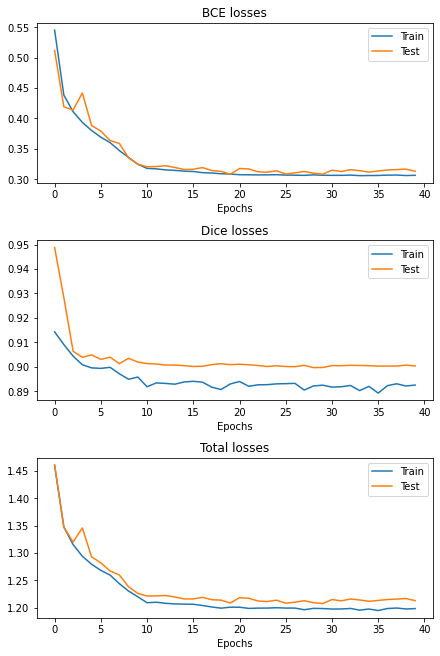

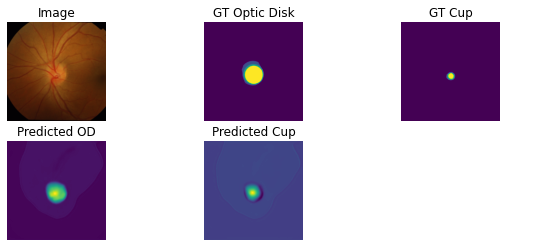

In [ ]:
train_and_evaluate(depth=5)

### Depth = 6

In [ ]:
view_model(depth=6)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

[1/40] - using time: 32.46 seconds
Training loss: 1.355
Validation loss: 1.434
[2/40] - using time: 32.48 seconds
Training loss: 1.251
Validation loss: 1.313
[3/40] - using time: 32.34 seconds
Training loss: 1.223
Validation loss: 1.230
[4/40] - using time: 32.34 seconds
Training loss: 1.199
Validation loss: 1.223
[5/40] - using time: 32.34 seconds
Training loss: 1.184
Validation loss: 1.192
[6/40] - using time: 33.20 seconds
Training loss: 1.168
Validation loss: 1.193
[7/40] - using time: 32.31 seconds
Training loss: 1.157
Validation loss: 1.178
[8/40] - using time: 32.61 seconds
Training loss: 1.141
Validation loss: 1.150
[9/40] - using time: 32.36 seconds
Training loss: 1.127
Validation loss: 1.144
[10/40] - using time: 32.28 seconds
Training loss: 1.116
Validation loss: 1.128
[11/40] - using time: 32.39 seconds
Training loss: 1.109
Validation loss: 1.125
[12/40] - using time: 32.34 seconds
Training loss: 1.108
Validation loss: 1.121
[13/40] - using time: 32.31 seconds
Training loss

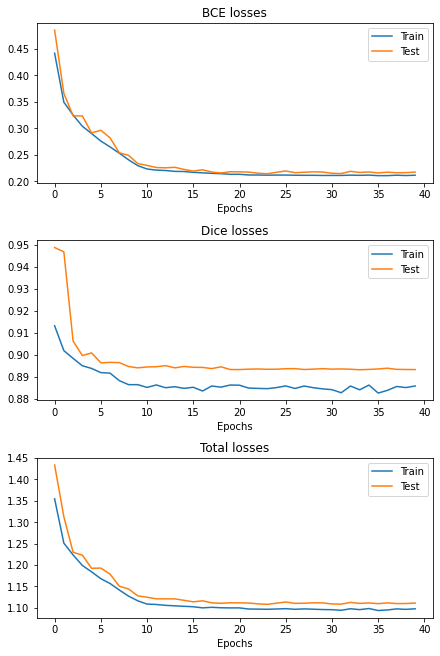

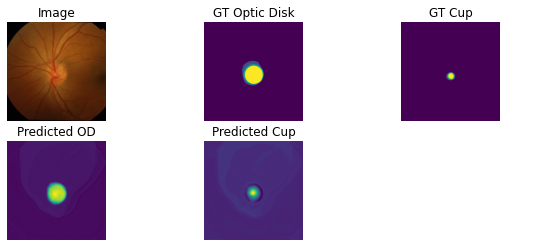

In [ ]:
train_and_evaluate(depth=6)

## External Links

- Overleaf document of project report: https://www.overleaf.com/read/tyhtkpmqmcpv
- Project guidelines: https://www.eecs.umich.edu/courses/eecs442-ahowens/fa22/psets/project-guidelines.pdf
- Project proposal: https://docs.google.com/document/d/1A0P16xcD7QWkJ3yK5ymEI086o-2IqY794R8RkvewLJw/edit?usp=sharing

In [ ]:
!pip install voila
!voila

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.4 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 106 kB 67.2 MB/s 
     |████████████████████████████████| 273 kB 76.2 MB/s 
     |████████████████████████████████| 71 kB 460 kB/s 
     |████████████████████████████████| 346 kB 73.2 MB/s 
     |████████████████████████████████| 423 kB 80.8 MB/s 
     |████████████████████████████████| 80 kB 12.6 MB/s 
     |████████████████████████████████| 55 kB 4.5 MB/s 
     |████████████████████████████████| 133 kB 78.9 MB/s 
     |████████████████████████████████| 62 kB 2.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 6.0.4
    Uninstalling tornado-6.0.4:
      Successfully uninstalled tornado-6.0.4
  Attempting uninstall: mistune
    Found existing installat

[Voila] Using /tmp to store connection files
[Voila] Storing connection files in /tmp/voila_zyppyz3w.
[Voila] Serving static files from /usr/local/lib/python3.8/dist-packages/voila/static.
[Voila] Voilà is running at:
http://localhost:8866/
[Voila] WARNING | No web browser found: could not locate runnable browser.
